In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sweety18/cicids2017-full-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cicids2017-full-dataset' dataset.
Path to dataset files: /kaggle/input/cicids2017-full-dataset


In [ ]:
import os
files = [f for f in os.listdir(path) if f.endswith(".csv")]
print(files)


['combine.csv']


In [ ]:

df = pd.read_csv(os.path.join(path, files[0]))

print(f" Dataset loaded successfully!")
print(f" Shape: {df.shape}")
print(f" Columns: {df.shape[1]}")
print(f" Samples: {df.shape[0]:,}")

df.head()

 Dataset loaded successfully!
 Shape: (2214469, 79)
 Columns: 79
 Samples: 2,214,469


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


 CLASS DISTRIBUTION ANALYSIS

 Attack Types Distribution:
 Label
BENIGN              1672837
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
DoS slowloris          5796
DoS Slowhttptest       5499
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64

 Percentage Distribution:
BENIGN                        : 1,672,837 ( 75.54%)
DoS Hulk                      :  231,073 ( 10.43%)
PortScan                      :  158,930 (  7.18%)
DDoS                          :  128,027 (  5.78%)
DoS GoldenEye                 :   10,293 (  0.46%)
DoS slowloris                 :    5,796 (  0.26%)
DoS Slowhttptest              :    5,499 (  0.25%)
Bot                           :    1,966 (  0.09%)
Infiltration                  :       36 (  0.00%)
Heartbleed                    :       11 (  0.00%)

 Critically Imbalanced Classes (< 100 samples):
  - Infiltration: 36 samples ← VERY RARE!


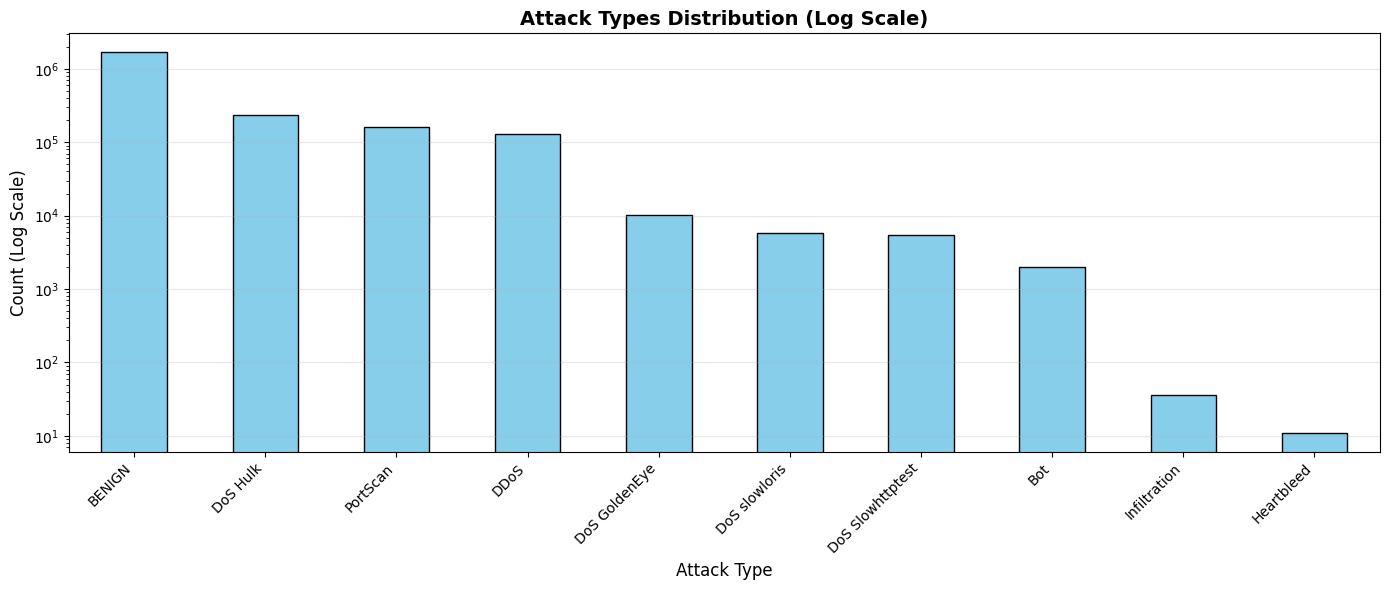


 EDA completed!


In [ ]:

print("="*80)
print(" CLASS DISTRIBUTION ANALYSIS")
print("="*80)

class_counts = df[' Label'].value_counts()
print("\n Attack Types Distribution:")
print(class_counts)
print("\n Percentage Distribution:")
for label, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{label:30s}: {count:8,d} ({percentage:6.2f}%)")


print("\n Critically Imbalanced Classes (< 100 samples):")
rare_classes = class_counts[class_counts < 100]
for label, count in rare_classes.items():
    print(f"  - {label}: {count} samples ← VERY RARE!")

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Attack Types Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n EDA completed!")

In [ ]:

print("="*80)
print(" DATA CLEANING - INITIAL CHECKS")
print("="*80)


num_duplicates = df.duplicated().sum()
print(f"\n Duplicate rows found: {num_duplicates:,} ({(num_duplicates/len(df)*100):.2f}%)")

if num_duplicates > 0:
    print(" WARNING: Duplicates detected! Will be handled after train/test split.")

missing_values = df.isnull().sum().sum()
print(f" Missing values: {missing_values}")


inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
print(f" Infinite values: {inf_count}")

 DATA CLEANING - INITIAL CHECKS

 Duplicate rows found: 271,280 (12.25%)
 Missing values: 1215
 Infinite values: 3735


In [ ]:

def clean_dataset(df):

    print("\n Cleaning dataset...")


    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    before_rows = len(df)


    df.dropna(inplace=True)
    after_rows = len(df)
    print(f"   Removed {before_rows - after_rows:,} rows with Inf/NaN")


    unique_counts = df.nunique()
    cols_to_drop = unique_counts[unique_counts <= 1].index
    if len(cols_to_drop) > 0:
        df.drop(columns=cols_to_drop, inplace=True)
        print(f"   Removed {len(cols_to_drop)} zero-variance columns")

    return df

df = clean_dataset(df)

print(f"\n Dataset after cleaning:")
print(f"  Shape: {df.shape}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


 Cleaning dataset...
   Removed 2,439 rows with Inf/NaN
   Removed 8 zero-variance columns

 Dataset after cleaning:
  Shape: (2212030, 71)
  Memory usage: 1374.01 MB


In [ ]:
df = clean_dataset(df)


 Cleaning dataset...
   Removed 0 rows with Inf/NaN


In [ ]:

print("="*80)
print(" CORRELATION ANALYSIS")
print("="*80)


corr_matrix = df.drop(' Label', axis=1).corr().abs()


upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"\n Features with correlation > 95%: {len(to_drop)}")
if len(to_drop) > 0:
    print(" Features to remove:")
    for feat in to_drop[:10]:  # Show first 10
        print(f"  - {feat}")
    if len(to_drop) > 10:
        print(f"  ... and {len(to_drop)-10} more")

    df.drop(columns=to_drop, inplace=True)
    print(f"\n Removed {len(to_drop)} highly correlated features")

print(f"\n Remaining features: {df.shape[1] - 1}")

 CORRELATION ANALYSIS

 Features with correlation > 95%: 24
 Features to remove:
  -  Total Backward Packets
  -  Total Length of Bwd Packets
  -  Fwd Packet Length Std
  -  Bwd Packet Length Mean
  -  Bwd Packet Length Std
  - Fwd IAT Total
  -  Fwd IAT Max
  - Fwd Packets/s
  -  Packet Length Std
  -  SYN Flag Count
  ... and 14 more

 Removed 24 highly correlated features

 Remaining features: 46


In [ ]:

print("="*80)
print(" FEATURE ENGINEERING")
print("="*80)

def engineer_features(df):

    print("\n Creating derived features...")

    if 'Total Length of Fwd Packets' in df.columns and ' Total Fwd Packets' in df.columns:
        df['Bytes_Per_Fwd_Packet'] = df['Total Length of Fwd Packets'] / (df[' Total Fwd Packets'] + 1)
        print("   Added: Bytes per forward packet")

    if ' Flow Packets/s' in df.columns:
        df['Packet_Rate_Log'] = np.log1p(df[' Flow Packets/s'])
        print("   Added: Log packet rate")


    if ' Packet Length Variance' in df.columns:
        df['Packet_Variance_Log'] = np.log1p(df[' Packet Length Variance'])
        print("   Added: Log packet variance")

    if ' Flow Duration' in df.columns and ' Total Fwd Packets' in df.columns:
        df['Duration_Per_Packet'] = df[' Flow Duration'] / (df[' Total Fwd Packets'] + 1)
        print("   Added: Duration per packet")

    return df


df = engineer_features(df)

print(f"\n Total features after engineering: {df.shape[1] - 1}")

 FEATURE ENGINEERING

 Creating derived features...
   Added: Bytes per forward packet
   Added: Log packet rate
   Added: Log packet variance
   Added: Duration per packet

 Total features after engineering: 50


In [ ]:

print("="*80)
print(" TRAIN/TEST SPLIT - PROPER METHOD")
print("="*80)


le = LabelEncoder()
y = le.fit_transform(df[' Label'])
X = df.drop(' Label', axis=1)

print("\n Splitting dataset (80% train, 20% test)...")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
    shuffle=True
)


train_df = pd.DataFrame(X_train_full, columns=X.columns)
train_df['label'] = y_train_full

print(f" Initial Train shape: {train_df.shape}")


before_dedup = len(train_df)
train_df.drop_duplicates(inplace=True)


train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

after_dedup = len(train_df)
print(f"   Removed {before_dedup - after_dedup:,} duplicate/NaN rows from training")


X_train_full = train_df.drop('label', axis=1).values
y_train_full = train_df['label'].values.astype(int)

print(f"\n Final dataset sizes:")
print(f"  Training: {X_train_full.shape[0]:,} samples")
print(f"  Testing: {X_test.shape[0]:,} samples")

 TRAIN/TEST SPLIT - PROPER METHOD

 Splitting dataset (80% train, 20% test)...
 Initial Train shape: (1769624, 51)
   Removed 201,717 duplicate/NaN rows from training

 Final dataset sizes:
  Training: 1,567,907 samples
  Testing: 442,406 samples


In [ ]:

print("="*80)
print(" FEATURE SELECTION")
print("="*80)

print("\n Training Random Forest for feature importance...")
print(" This may take a few minutes...")

sample_size = min(100000, len(X_train_full))
sample_indices = np.random.choice(len(X_train_full), sample_size, replace=False)

rf = RandomForestClassifier(
    n_estimators=50,
    n_jobs=-1,
    random_state=42,
    max_depth=10
)

rf.fit(X_train_full[sample_indices], y_train_full[sample_indices])

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

top_n = 40
important_cols = importances.head(top_n).index.tolist()

print(f"\n Feature selection complete!")
print(f" Selected top {top_n} features")
print(f"\n Top 10 most important features:")
for i, (feat, importance) in enumerate(importances.head(10).items(), 1):
    print(f"  {i:2d}. {feat:40s}: {importance:.4f}")


X_train_full = pd.DataFrame(X_train_full, columns=X.columns)[important_cols].values
X_test = pd.DataFrame(X_test, columns=X.columns)[important_cols].values

print(f"\n Reduced features from {len(X.columns)} → {top_n}")

 FEATURE SELECTION

 Training Random Forest for feature importance...
 This may take a few minutes...

 Feature selection complete!
 Selected top 40 features

 Top 10 most important features:
   1. Bwd Packet Length Max                   : 0.1090
   2. Packet_Variance_Log                     : 0.0820
   3.  Packet Length Variance                 : 0.0781
   4. Total Length of Fwd Packets             : 0.0557
   5.  Packet Length Mean                     : 0.0528
   6.  Fwd Packet Length Mean                 : 0.0503
   7.  Max Packet Length                      : 0.0466
   8. Bytes_Per_Fwd_Packet                    : 0.0381
   9.  Fwd Header Length                      : 0.0339
  10.  Flow IAT Std                           : 0.0326

 Reduced features from 50 → 40


In [ ]:
X_train_full = np.nan_to_num(X_train_full, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

X_train_full = X_train_full.clip(min=0)
X_test = X_test.clip(min=0)

X_train_full = np.log1p(X_train_full)
X_test = np.log1p(X_test)

In [ ]:

print("="*80)
print(" TRAIN/VALIDATION SPLIT")
print("="*80)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(f" Split complete:")
print(f"  Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X_train_full)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X_train_full)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]:,} samples")

 TRAIN/VALIDATION SPLIT
 Split complete:
  Training: 1,254,325 samples (80.0%)
  Validation: 313,582 samples (20.0%)
  Test: 442,406 samples


In [ ]:

print("="*80)
print(" HANDLING CLASS IMBALANCE")
print("="*80)


print("\n Deep checking for NaN/Inf/String values in training data...")


X_train_clean = pd.DataFrame(X_train)


X_train_clean = X_train_clean.apply(pd.to_numeric, errors='coerce')


X_train_clean.replace([np.inf, -np.inf], np.nan, inplace=True)


if X_train_clean.isnull().values.any():
    initial_len = len(X_train_clean)


    X_train_clean['TARGET_TEMP'] = y_train


    X_train_clean.dropna(inplace=True)


    y_train = X_train_clean['TARGET_TEMP'].values.astype(int)
    X_train = X_train_clean.drop('TARGET_TEMP', axis=1).values

    dropped_count = initial_len - len(X_train_clean)
    print(f" Found and removed {dropped_count:,} bad samples (NaN/Inf)!")
else:
    print(" Training data is perfectly clean.")

print("\n Class distribution BEFORE SMOTE:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.classes_[cls]:30s}: {count:8,d}")


counts_dict = pd.Series(y_train).value_counts()
strategy = {label: max(count, 5000) for label, count in counts_dict.items()}

print("\n Applying SMOTE (Synthetic Minority Oversampling)...")
print(" This may take a few minutes...")

smote = SMOTE(
    sampling_strategy=strategy,
    k_neighbors=5,
    random_state=42
)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\n SMOTE applied successfully!")
print("\n Class distribution AFTER SMOTE:")
unique, counts = np.unique(y_train_res, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.classes_[cls]:30s}: {count:8,d}")

print(f"\n Training set size: {len(y_train):,} → {len(y_train_res):,}")

 HANDLING CLASS IMBALANCE

 Deep checking for NaN/Inf/String values in training data...
 Training data is perfectly clean.

 Class distribution BEFORE SMOTE:
  BENIGN                        :  984,152
  Bot                           :    1,247
  DDoS                          :   81,935
  DoS GoldenEye                 :    6,583
  DoS Hulk                      :  110,725
  DoS Slowhttptest              :    3,362
  DoS slowloris                 :    3,468
  Heartbleed                    :        7
  Infiltration                  :       23
  PortScan                      :   62,823

 Applying SMOTE (Synthetic Minority Oversampling)...
 This may take a few minutes...

 SMOTE applied successfully!

 Class distribution AFTER SMOTE:
  BENIGN                        :  984,152
  Bot                           :    5,000
  DDoS                          :   81,935
  DoS GoldenEye                 :    6,583
  DoS Hulk                      :  110,725
  DoS Slowhttptest              :    5,000
  Do

In [ ]:

from tensorflow.keras.utils import to_categorical

print("="*80)
print(" ONE-HOT ENCODING LABELS")
print("="*80)

print("\n Converting labels to one-hot vectors...")

# Define num_classes using the LabelEncoder
num_classes = len(le.classes_)

y_train_final = to_categorical(y_train_res, num_classes)
y_val_final = to_categorical(y_val, num_classes)
y_test_final = to_categorical(y_test, num_classes)

print(f" One-hot encoding complete")
print(f"  Training shape: {y_train_final.shape}")
print(f"  Validation shape: {y_val_final.shape}")
print(f"  Test shape: {y_test_final.shape}")

 ONE-HOT ENCODING LABELS

 Converting labels to one-hot vectors...
 One-hot encoding complete
  Training shape: (1271218, 10)
  Validation shape: (313582, 10)
  Test shape: (442406, 10)


In [ ]:

print("="*80)
print(" FEATURE SCALING")
print("="*80)

print("\n Applying RobustScaler...")
print("WHY: Handles outliers better than StandardScaler")


print(" Sanitizing data (replacing Inf/NaN with 0) before scaling...")


X_train_res = np.nan_to_num(X_train_res, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.astype('float32')
X_val_scaled = X_val_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

print(f" Scaling complete")
print(f"  Training: {X_train_scaled.shape}")
print(f"  Validation: {X_val_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")


print(f"\n Sanity check:")
print(f"  Max value in training: {X_train_scaled.max():.2f}")
print(f"  Min value in training: {X_train_scaled.min():.2f}")

 FEATURE SCALING

 Applying RobustScaler...
WHY: Handles outliers better than StandardScaler
 Sanitizing data (replacing Inf/NaN with 0) before scaling...
 Scaling complete
  Training: (1271218, 40)
  Validation: (313582, 40)
  Test: (442406, 40)

 Sanity check:
  Max value in training: 18.48
  Min value in training: -6.74


In [ ]:

print("="*80)
print(" BUILDING IMPROVED DEEP LEARNING MODEL")
print("="*80)

def focal_loss(gamma=1.5, alpha=0.0025):

    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed


def build_improved_model(input_shape, num_classes):

    model = models.Sequential()

    model.add(layers.Input(shape=(input_shape,)))


    model.add(layers.Dense(
        512,
        kernel_regularizer=regularizers.l2(0.000001)
    ))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(
        256,
        kernel_regularizer=regularizers.l2(0.000001)
    ))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))


    model.add(layers.Dense(
        128,
        kernel_regularizer=regularizers.l2(0.00001)
    ))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))


    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.BatchNormalization())


    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


input_dim = X_train_scaled.shape[1]
model = build_improved_model(input_dim, num_classes)


optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy',
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

print("\n Model built successfully with IMPROVED regularization!")
print("\n Model summary:")
model.summary()

print("\n Key improvements:")
print("  1.  Added L2 regularization (weight decay)")
print("  2.  Increased dropout rates (prevents overfitting)")
print("  3.  Using focal loss (handles imbalance)")

 BUILDING IMPROVED DEEP LEARNING MODEL

 Model built successfully with IMPROVED regularization!

 Model summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,962 (773.29 KB)

 Trainable params: 196,042 (765.79 KB)

 Non-trainable params: 1,920 (7.50 KB)


 Key improvements:
  1.  Added L2 regularization (weight decay)
  2.  Increased dropout rates (prevents overfitting)
  3.  Using focal loss (handles imbalance)


In [ ]:

print("="*80)
print(" TRAINING MODEL")
print("="*80)


early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.0005,
    patience=3,
    min_lr=0.0001,
    verbose=1
)


history = model.fit(
    X_train_scaled, y_train_final,
    epochs=5,
    batch_size=1048,
    validation_data=(X_val_scaled, y_val_final),
    callbacks=[early_stop, reduce_lr],  # EDIT: Added reduce_lr
)

print("\n Training complete!")

 TRAINING MODEL
Epoch 1/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.7740 - loss: 0.3440 - precision_1: 0.8882 - recall_1: 0.5719 - val_accuracy: 0.9891 - val_loss: 0.0138 - val_precision_1: 0.9917 - val_recall_1: 0.9864 - learning_rate: 1.0000e-04
Epoch 2/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9809 - loss: 0.0229 - precision_1: 0.9867 - recall_1: 0.9710 - val_accuracy: 0.9942 - val_loss: 0.0074 - val_precision_1: 0.9950 - val_recall_1: 0.9937 - learning_rate: 1.0000e-04
Epoch 3/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9867 - loss: 0.0133 - precision_1: 0.9896 - recall_1: 0.9826 - val_accuracy: 0.9955 - val_loss: 0.0057 - val_precision_1: 0.9960 - val_recall_1: 0.9951 - learning_rate: 1.0000e-04
Epoch 4/5
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9895 - loss: 0.0097 - precision_1: 0.9912 - recall_1: 0.9872 - val_accuracy: 0.9962 - val_loss: 0.0048 - val_precision_1: 0.9964 - val_recall_1: 0.9958 - learning_rate: 1.000

 TRAINING HISTORY VISUALIZATION


KeyError: 'precision'

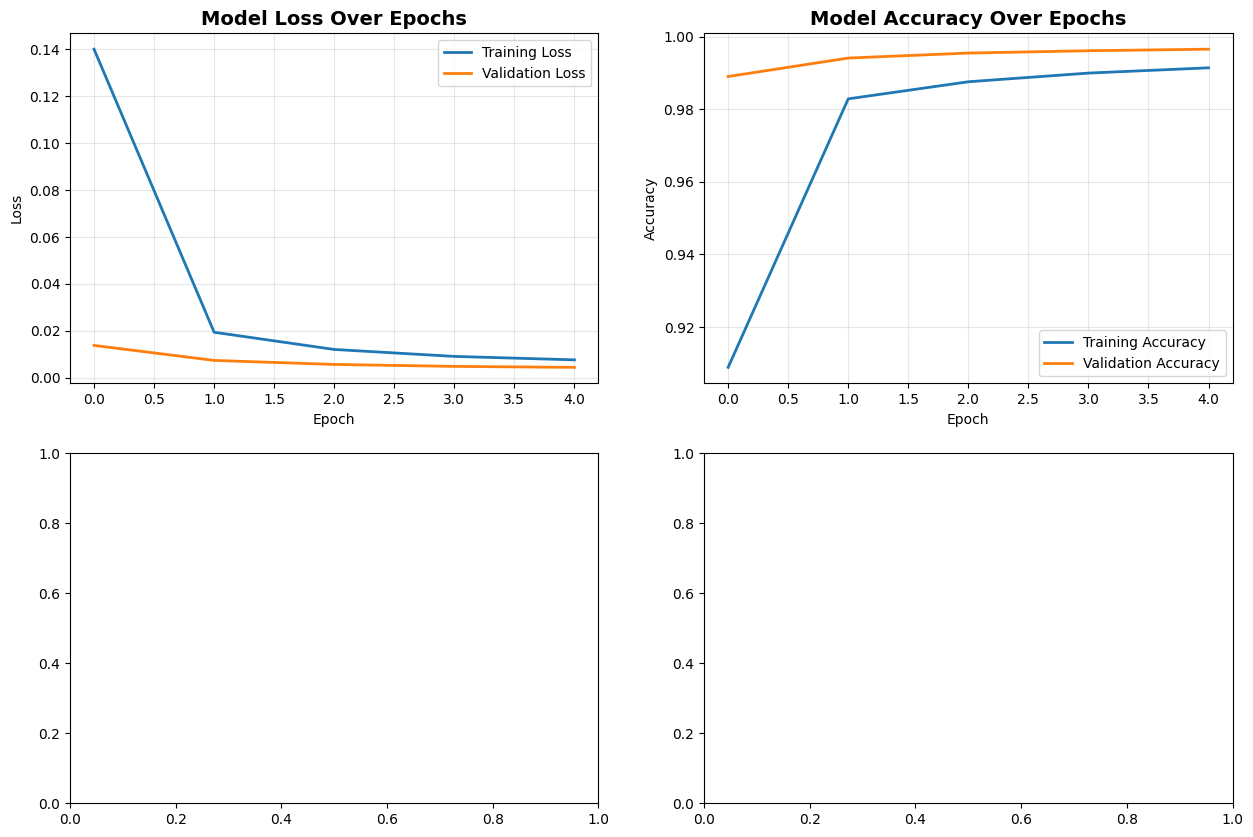

In [ ]:

print("="*80)
print(" TRAINING HISTORY VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))


axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)


axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision Over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)


axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall Over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Training curves saved as 'training_history.png'")


final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
gap = abs(final_train_acc - final_val_acc)

print("\n Overfitting analysis:")
print(f"  Final training accuracy: {final_train_acc:.4f}")
print(f"  Final validation accuracy: {final_val_acc:.4f}")
print(f"  Gap: {gap:.4f}")

if gap < 0.02:
    print("   Model is well-balanced (gap < 2%)")
elif gap < 0.05:
    print("   Minor overfitting detected (2% < gap < 5%)")
else:
    print("   Significant overfitting detected (gap > 5%)")

In [ ]:

print("="*80)
print(" FINAL EVALUATION ON TEST SET")
print("="*80)

print("\n Predicting on test set (unseen data)...")
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_final, axis=1)

print("\n" + "="*80)
print(" CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\n" + "="*80)
print(" OVERALL METRICS")
print("="*80)
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")

 FINAL EVALUATION ON TEST SET

 Predicting on test set (unseen data)...
13826/13826 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step

 CLASSIFICATION REPORT
                  precision    recall  f1-score   support

          BENIGN     0.9670    0.9985    0.9825    334297
             Bot     0.5704    0.6113    0.5901       391
            DDoS     0.9990    0.9987    0.9988     25605
   DoS GoldenEye     0.9890    0.9611    0.9749      2059
        DoS Hulk     0.9979    0.7590    0.8622     46025
DoS Slowhttptest     0.9369    0.9182    0.9275      1100
   DoS slowloris     0.9302    0.9318    0.9310      1159
      Heartbleed     0.5000    0.5000    0.5000         2
    Infiltration     0.1081    0.5714    0.1818         7
        PortScan     0.9943    0.9987    0.9965     31761

        accuracy                         0.9727    442406
       macro avg     0.7993    0.8249    0.7945    442406
    weighted avg     0.9736    0.9727    0.9713    442406


 OVERALL METRICS
Accuracy:  0.9727
Precisi

 CONFUSION MATRIX


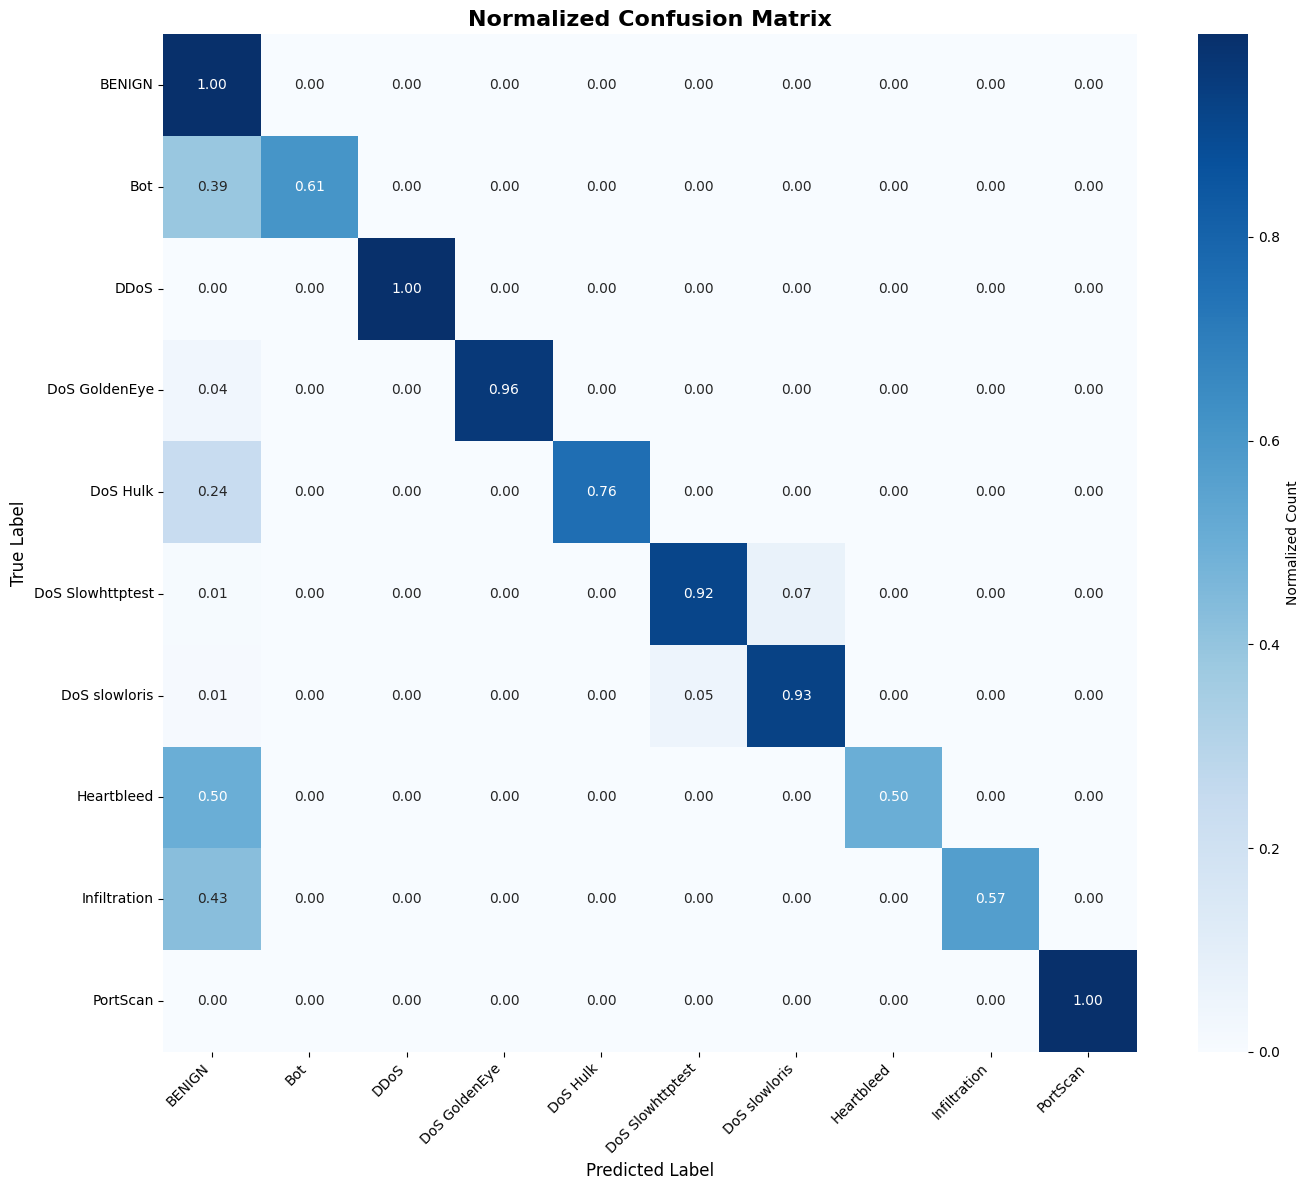


 Confusion matrix saved as 'confusion_matrix.png'


In [ ]:

print("="*80)
print(" CONFUSION MATRIX")
print("="*80)

plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_true, y_pred)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Normalized Count'}
)

plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Confusion matrix saved as 'confusion_matrix.png'")

In [ ]:

print("="*80)
print(" OVERFITTING DETECTION TEST")
print("="*80)

print("\n" + "-"*80)
print("TEST 1: Real Test Samples (should be HIGH confidence)")
print("-"*80)


random_indices = np.random.choice(len(X_test_scaled), size=10, replace=False)
samples = X_test_scaled[random_indices]
true_labels = np.argmax(y_test_final[random_indices], axis=1)

predictions_probs = model.predict(samples, verbose=0)
pred_labels = np.argmax(predictions_probs, axis=1)

correct = 0
for i in range(10):
    true_name = le.classes_[true_labels[i]]
    pred_name = le.classes_[pred_labels[i]]
    confidence = np.max(predictions_probs[i]) * 100

    if true_name == pred_name:
        correct += 1



    print(f"Sample {i+1:2d}: True=[{true_name:15s}] Pred=[{pred_name:15s}] Conf={confidence:5.2f}% ")

print(f"\n Accuracy on real samples: {correct}/10 ({correct*10}%)")

print("\n" + "-"*80)
print("TEST 2: Random Noise (should be LOW confidence & distributed)")
print("-"*80)


print("\n Testing with Gaussian noise (mean=0, std=1)...")
noise_gaussian = np.random.normal(0, 1, size=(10, X_test_scaled.shape[1]))
noise_preds = model.predict(noise_gaussian, verbose=0)

confidence_sum = 0
predictions_dist = {}

for i in range(10):
    pred_name = le.classes_[np.argmax(noise_preds[i])]
    confidence = np.max(noise_preds[i]) * 100
    confidence_sum += confidence

    predictions_dist[pred_name] = predictions_dist.get(pred_name, 0) + 1

    print(f"Noise {i+1:2d}: Predicted=[{pred_name:15s}] Confidence={confidence:5.2f}%")

avg_confidence = confidence_sum / 10

print("\n Analysis of noise predictions:")
print(f"  Average confidence: {avg_confidence:.2f}%")
print(f"  Predictions distribution: {predictions_dist}")

print("\n Interpretation:")
if avg_confidence > 80:
    print("   HIGH OVERCONFIDENCE detected! Model is overfitted.")
    print("     A well-calibrated model should have ~20-40% confidence on noise.")
elif avg_confidence > 60:
    print("   MODERATE overconfidence. Some overfitting present.")
else:
    print("   Good! Model is appropriately uncertain about noise.")

if len(predictions_dist) <= 2:
    print("   Model predicts only 1-2 classes for noise (overconfident behavior)")
elif len(predictions_dist) <= 5:
    print("   Model shows some diversity in noise predictions")
else:
    print("   Good! Model predictions are well-distributed across classes")

 OVERFITTING DETECTION TEST

--------------------------------------------------------------------------------
TEST 1: Real Test Samples (should be HIGH confidence)
--------------------------------------------------------------------------------
Sample  1: True=[DDoS           ] Pred=[DDoS           ] Conf=98.98% 
Sample  2: True=[PortScan       ] Pred=[PortScan       ] Conf=99.31% 
Sample  3: True=[BENIGN         ] Pred=[BENIGN         ] Conf=80.32% 
Sample  4: True=[PortScan       ] Pred=[PortScan       ] Conf=88.20% 
Sample  5: True=[BENIGN         ] Pred=[BENIGN         ] Conf=93.45% 
Sample  6: True=[BENIGN         ] Pred=[BENIGN         ] Conf=95.48% 
Sample  7: True=[BENIGN         ] Pred=[BENIGN         ] Conf=95.27% 
Sample  8: True=[BENIGN         ] Pred=[BENIGN         ] Conf=93.62% 
Sample  9: True=[PortScan       ] Pred=[PortScan       ] Conf=99.25% 
Sample 10: True=[BENIGN         ] Pred=[BENIGN         ] Conf=95.50% 

 Accuracy on real samples: 10/10 (100%)

-------------

In [ ]:

print("="*80)
print(" MODEL CALIBRATION - Temperature Scaling")
print("="*80)

print("\n Calibrating model to reduce overconfidence...")
print("WHY: Even well-trained models can be overconfident")

from scipy.optimize import minimize
from tensorflow.keras import models

def temperature_scale(logits, temperature):

    return logits / temperature

def find_optimal_temperature(y_true, y_pred_logits):

    from tensorflow.keras.losses import CategoricalCrossentropy

    def objective(temp):

        t = max(temp[0], 0.01)
        scaled_logits = temperature_scale(y_pred_logits, t)
        scaled_probs = tf.nn.softmax(scaled_logits).numpy()
        loss = CategoricalCrossentropy()(y_true, scaled_probs)
        return loss.numpy()

    result = minimize(objective, x0=[1.0], bounds=[(0.1, 5.0)], method='L-BFGS-B')
    return result.x[0]

print("\n Computing logits manually from validation set...")


feature_model = models.Sequential(model.layers[:-1])


val_features = feature_model.predict(X_val_scaled, verbose=0)

final_layer = model.layers[-1]
W, b = final_layer.get_weights()


val_logits = np.dot(val_features, W) + b

optimal_temp = find_optimal_temperature(y_val_final, val_logits)

print(f"\n Optimal temperature found: {optimal_temp:.4f}")

if optimal_temp > 1.5:
    print("   High temperature needed → Model was VERY overconfident")
elif optimal_temp > 1.1:
    print("   Moderate temperature → Model was somewhat overconfident")
else:
    print("   Low temperature → Model is well-calibrated")


import json
with open('model_temperature.json', 'w') as f:
    json.dump({'temperature': float(optimal_temp)}, f)

print("\n Temperature saved to 'model_temperature.json'")
print("   Use this temperature during inference for calibrated predictions!")

 MODEL CALIBRATION - Temperature Scaling

 Calibrating model to reduce overconfidence...
WHY: Even well-trained models can be overconfident

 Computing logits manually from validation set...

 Optimal temperature found: 1.0000
   Low temperature → Model is well-calibrated

 Temperature saved to 'model_temperature.json'
   Use this temperature during inference for calibrated predictions!


In [ ]:

print("="*80)
print(" SAVING MODEL AND PREPROCESSING OBJECTS")
print("="*80)

import joblib


model.save('best_ids_model.keras')
print("\n Model saved: 'best_ids_model.keras'")

joblib.dump(scaler, 'robust_scaler.pkl')
print(" Scaler saved: 'robust_scaler.pkl'")

joblib.dump(le, 'label_encoder.pkl')
print(" Label encoder saved: 'label_encoder.pkl'")

with open('feature_names.json', 'w') as f:
    json.dump(important_cols, f)
print(" Feature names saved: 'feature_names.json'")

print("\n All files saved! Ready for deployment.")
print("\n Deployment checklist:")
print("  1.  best_ids_model.keras (neural network)")
print("  2.  robust_scaler.pkl (feature scaling)")
print("  3.  label_encoder.pkl (label decoding)")
print("  4.  feature_names.json (feature selection)")
print("  5.  model_temperature.json (calibration)")


 SAVING MODEL AND PREPROCESSING OBJECTS

 Model saved: 'best_ids_model.keras'
 Scaler saved: 'robust_scaler.pkl'
 Label encoder saved: 'label_encoder.pkl'
 Feature names saved: 'feature_names.json'

 All files saved! Ready for deployment.

 Deployment checklist:
  1.  best_ids_model.keras (neural network)
  2.  robust_scaler.pkl (feature scaling)
  3.  label_encoder.pkl (label decoding)
  4.  feature_names.json (feature selection)
  5.  model_temperature.json (calibration)


In [ ]:

print("="*80)
print(" PRODUCTION INFERENCE CODE")
print("="*80)

class CyberAttackDetector:

    def __init__(self,
                 model_path='best_ids_model.keras',
                 scaler_path='robust_scaler.pkl',
                 encoder_path='label_encoder.pkl',
                 features_path='feature_names.json',
                 temp_path='model_temperature.json'):

        print(" Initializing CyberAttackDetector...")

        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={'focal_loss_fixed': focal_loss()}
        )

        self.scaler = joblib.load(scaler_path)
        self.encoder = joblib.load(encoder_path)

        with open(features_path, 'r') as f:
            self.feature_names = json.load(f)

        with open(temp_path, 'r') as f:
            self.temperature = json.load(f)['temperature']

        print(f" Detector ready! Using temperature={self.temperature:.4f}")

    def preprocess(self, features):

        if isinstance(features, np.ndarray):
            features = pd.DataFrame(features, columns=self.feature_names)

        features = features[self.feature_names]

        features = np.log1p(features)

        features = self.scaler.transform(features)

        return features.astype('float32')

    def predict(self, network_packet, use_temperature=True):

        processed = self.preprocess(network_packet)

        logits = self.model.predict(processed, verbose=0)

        if use_temperature:
            logits = logits / self.temperature

        probs = tf.nn.softmax(logits).numpy()[0]

        pred_idx = np.argmax(probs)
        attack_type = self.encoder.classes_[pred_idx]
        confidence = float(probs[pred_idx])

        return {
            'attack_type': attack_type,
            'confidence': confidence,
            'is_attack': attack_type != 'BENIGN',
            'all_probabilities': {cls: float(prob) for cls, prob in zip(self.encoder.classes_, probs)}
        }

print("\n Testing production detector...")
detector = CyberAttackDetector()

test_sample = pd.DataFrame(X_test[0:1], columns=important_cols)
result = detector.predict(test_sample)

print("\n Example prediction:")
print(f"  Attack Type: {result['attack_type']}")
print(f"  Confidence: {result['confidence']:.2%}")
print(f"  Is Attack: {result['is_attack']}")

print("\n Production detector is working!")


 PRODUCTION INFERENCE CODE

 Testing production detector...
 Initializing CyberAttackDetector...
 Detector ready! Using temperature=1.0000



 Example prediction:
  Attack Type: BENIGN
  Confidence: 22.58%
  Is Attack: False

 Production detector is working!
